In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
import locale


# Функции

In [15]:
def load_and_preprocess_data(file_path):
    """
    Загружает данные из файла, преобразует даты и добавляет нужные столбцы.
    """
    data = pd.read_excel(file_path)
    data['service_date'] = pd.to_datetime(data['service_date'])
    data.drop_duplicates(inplace=True)

    # Добавляем год, месяц, возрастные группы
    data['year'] = data['service_date'].dt.year
    data['month'] = data['service_date'].dt.month

    bins = [0, 18, 35, 50, 65, 80, 100]
    labels = ["0-18", "19-35", "36-50", "51-65", "66-80", "81-100"]
    data['age_group'] = pd.cut(data['age_for_service_date'], bins=bins, labels=labels)
    return data


In [17]:
def calculate_metrics(data):
    """
    Вычисляет основные метрики, такие как уникальные пациенты, услуги и визиты.
    """
    metrics = {
        "unique_patients": data["insured"].nunique(),
        "unique_services": data["service_name"].nunique(),
        "unique_visits": data.groupby(["insured", "service_date"]).ngroups,
        "gender_distribution": data["sex_id"].value_counts(),
        "age_distribution": data["age_group"].value_counts().sort_index(),
        "monthly_distribution": data["month"].value_counts().sort_index(),
        "top_services": data["service_name"].value_counts().head(10)
    }
    return metrics


In [18]:
def plot_gender_distribution(data):
    gender_yearly = data.groupby(["year", "sex_id"]).size().reset_index(name="count")
    gender_yearly["sex_id"] = gender_yearly["sex_id"].map({1: "Мужчины", 2: "Женщины"})
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x="sex_id", y="count", hue="year", data=gender_yearly, edgecolor="black", alpha=0.85)
    plt.title("Распределение пациентов по полу (2021 vs 2022)")
    plt.xlabel("Пол")
    plt.ylabel("Количество пациентов")
    plt.legend(title="Год")
    plt.tight_layout()
    plt.show()


def plot_age_distribution(data):
    age_yearly = data.groupby(["year", "age_group"]).size().reset_index(name="count")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x="age_group", y="count", hue="year", data=age_yearly, edgecolor="black", alpha=0.85)
    plt.title("Распределение пациентов по возрастным группам (2021 vs 2022)")
    plt.xlabel("Возрастная группа")
    plt.ylabel("Количество пациентов")
    plt.xticks(rotation=45)
    plt.legend(title="Год")
    plt.tight_layout()
    plt.show()


def plot_top_services(metrics):
    top_services = metrics["top_services"]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_services.values, y=top_services.index, palette="magma", edgecolor="black", alpha=0.85)
    plt.title("Топ-10 самых популярных услуг")
    plt.xlabel("Количество оказанных услуг")
    plt.ylabel("Название услуги")
    plt.tight_layout()
    plt.show()


In [19]:
def убрать_выбросы(series, multiplier=3):
    """
    Удаляет выбросы из данных на основе межквартильного размаха.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    нижняя_граница = q1 - multiplier * iqr
    верхняя_граница = q3 + multiplier * iqr
    return series[(series >= нижняя_граница) & (series <= верхняя_граница)]


def проверка_гипотез(data_2021, data_2022):
    выводы = []

    # 1. Средняя стоимость услуг
    стоимость_2021 = убрать_выбросы(data_2021['service_amount'])
    стоимость_2022 = убрать_выбросы(data_2022['service_amount'])
    t_stat, p_val_ttest = ttest_ind(стоимость_2021, стоимость_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    выводы.append(["Средняя стоимость услуг", "Средняя стоимость услуг изменилась.", p_val_ttest, результат])

    # 2. Интенсивность лечения
    интенсивность_2021 = data_2021.groupby('insured')['service_number'].sum()
    интенсивность_2022 = data_2022.groupby('insured')['service_number'].sum()
    интенсивность_2021 = убрать_выбросы(интенсивность_2021)
    интенсивность_2022 = убрать_выбросы(интенсивность_2022)
    t_stat, p_val_ttest = ttest_ind(интенсивность_2021, интенсивность_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    выводы.append(["Интенсивность лечения", "Интенсивность лечения изменилась.", p_val_ttest, результат])

    # 3. Распределение пациентов по полу
    пол_2021 = data_2021['sex_id'].value_counts()
    пол_2022 = data_2022['sex_id'].value_counts()
    chi2_stat, p_val_chi2, _, _ = chi2_contingency([пол_2021, пол_2022])
    результат = "Существенное изменение" if p_val_chi2 < 0.05 else "Нет значимого изменения"
    выводы.append(["Распределение по полу", "Распределение по полу изменилось.", p_val_chi2, результат])

    return выводы


In [20]:
def analyze_medical_data(file_path):
    """
    Основная функция анализа: загрузка, расчёты, визуализация и проверка гипотез.
    """
    data = load_and_preprocess_data(file_path)
    
    # Разделение данных по годам
    data_2021 = data[data["year"] == 2021]
    data_2022 = data[data["year"] == 2022]
    
    metrics = calculate_metrics(data)
    
    # Вывод метрик
    print(f"Уникальных пациентов: {metrics['unique_patients']}")
    print(f"Уникальных услуг: {metrics['unique_services']}")
    print(f"Уникальных визитов: {metrics['unique_visits']}")
    
    # Построение графиков
    plot_gender_distribution(data)
    plot_age_distribution(data)
    plot_top_services(metrics)
    
    # Проверка гипотез
    выводы = проверка_гипотез(data_2021, data_2022)
    for вывод in выводы:
        print(вывод)


Уникальных пациентов: 4488
Уникальных услуг: 875
Уникальных визитов: 30294


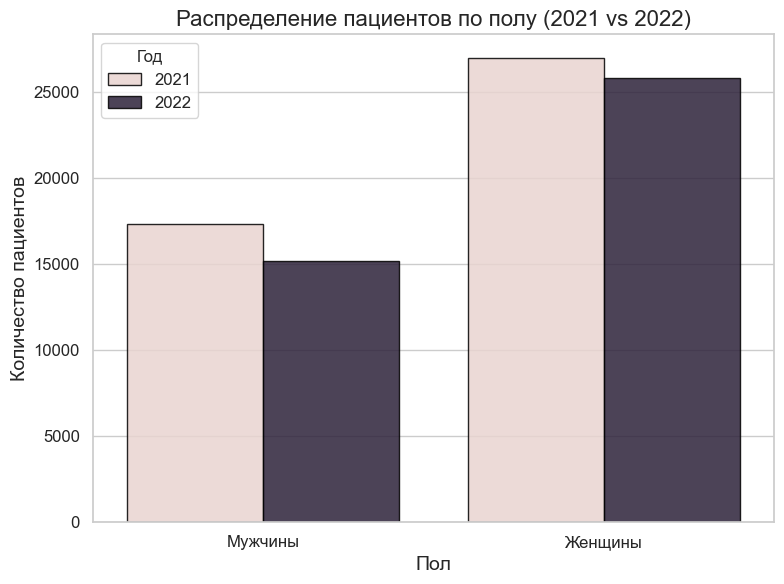

/var/folders/9d/hjcxrkbn309fh_6d5y39sdvm0000gn/T/ipykernel_1331/1710007019.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_yearly = data.groupby(["year", "age_group"]).size().reset_index(name="count")


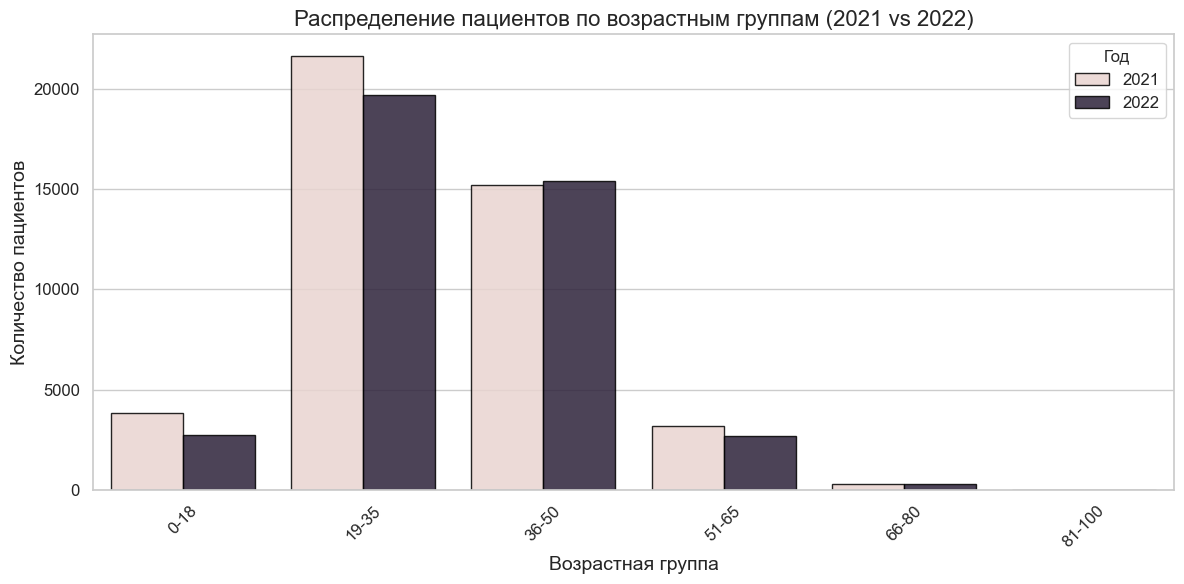

/var/folders/9d/hjcxrkbn309fh_6d5y39sdvm0000gn/T/ipykernel_1331/1710007019.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_services.values, y=top_services.index, palette="magma", edgecolor="black", alpha=0.85)


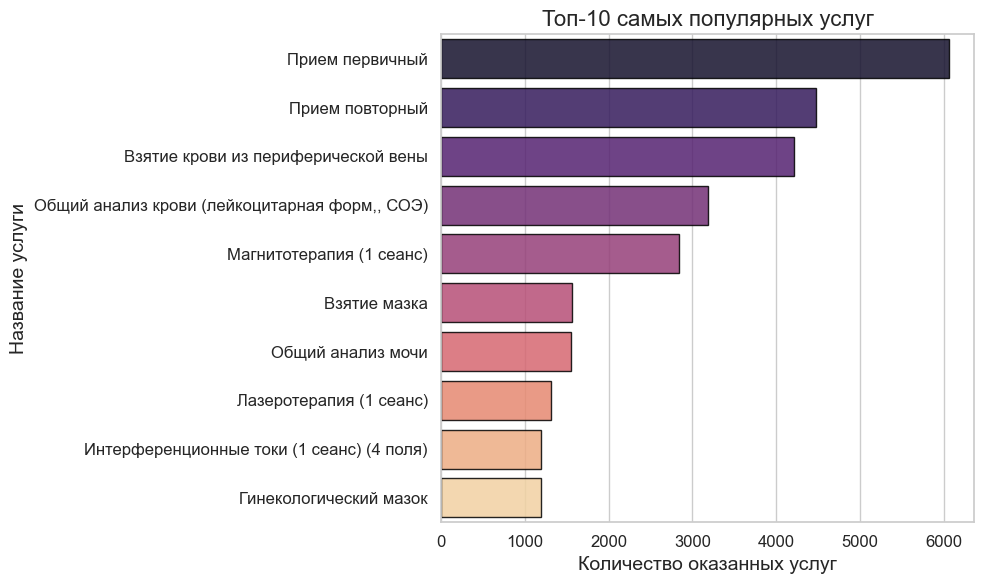

['Средняя стоимость услуг', 'Средняя стоимость услуг изменилась.', 2.719708459736441e-41, 'Существенное изменение']
['Интенсивность лечения', 'Интенсивность лечения изменилась.', 2.462876334363927e-10, 'Существенное изменение']
['Распределение по полу', 'Распределение по полу изменилось.', 4.3558559031400975e-10, 'Существенное изменение']


In [22]:
file_path = "/Users/viktoriasmeleva/Downloads/data_test_task_2022 (4).xlsx"  # Укажите путь к файлу
analyze_medical_data(file_path)

